<a href="https://colab.research.google.com/github/odmina/misbehaving_armadillos/blob/main/21th_July_Allen_Visual_Behavior_from_SDK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
The following notebook loads data from single behavioral session (one mouse) and one imaging experiment (just one plane) associated with that session to plot stimulus, licks and reward data and neural activity (one selected neuron). 

# Set up environment and import packages

We have built a package called `mindscope_utilities` which contains some useful convenience functions. The `allenSDK` is a dependency of this package and will be automatically installed when you install `mindscope_utilities` per the instrutions below.

We will first install `mindscope_utilities` into our colab environment by running the commands below. When this cell is complete, click on the `RESTART RUNTIME` button that appears at the end of the output. Note that running this cell will produce a long list of outputs and some error messages. Clicking `RESTART RUNTIME` at the end will resolve these issues. 

You can minimize the cell after you are done to hide the output. 

#### Install necessary packages

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

#### Next we will import packages we need later in the notebook

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Load the session and experiment summary tables

We download the data cache:

- `ophys_session_table` contains data describing imaging sessions - one session can contain more than one imaging experiment (more than one plane), and not all behavioral session are accompanied by imaging. contains metadata describing imaging sessions. If more than one plane was imaged during a session, one ophys session id will be associated multiple *ophys experiment ids*. Each ophys session id will also have a unique *behavior session id*
- `behavior_session_table` contains metadata describing behavioral sessions, which may or may not be during imaging. Behavior session ids that do not have *ophys session ids* were training sessions
- `ophys_experiment_table` contains metadata describing imaging experiments (aka imaging planes). When mesoscope is used, one ophys session may contain up to 8 unique experiments (two visual areas by four imaging depths). Some imaging planes may not be released due to quality control issues, thus each ophys session id is associated with anywhere from one to eight unique *experiment ids*. Ophys experiment ids are unique and do not repeat across sessions. To find the same imaging plane that was matched across multiple sessions, use the *ophys_container_id* column that can be found in both ophys_session_table and ophys_experiment_table

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

Then we can access the session and experiment tables directly.

Note that a 'session' is a single behavioral session. Sessions that are performed on the mesoscope will have multiple (up to 8) 'experiments' associated with them, where an experiment is a distinct imaging plane. 

In [4]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()
behavior_session_table = cache.get_behavior_session_table()

We can then view the contents of the session table. Note that this contains a lot of useful metadata about each session. One of the columns, `ophys_experiment_id` provides a list of the experiments (aka imaging planes) that are associated with each session.

In [5]:
session_table.head()
#session_table.session_type.unique()
#session_table.prior_exposures_to_image_set.unique()
#session_table.loc[ophys_session_id]
session_table.loc[951410079]
#session_table.shape[0]
#session_table.iloc[2].prior_exposures_to_image_set

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      457841
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                F
age_in_days                                                                      206
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     1
prior_exposures_to_session_type                                                    0
prior_exposures_to_image_set                                     

In [6]:
def def_novelty_session(session_table):
  session_table['novelty_session'] = session_table['prior_exposures_to_image_set'] == 0
  return session_table

session_table = def_novelty_session(session_table)
session_table.head()

#session_table_novel_sessions = [session_table['novelty_session'] == 'true']
#session_table_familiar_sessions = [session_table['novelty_session']=='false']
#print(session_table_novel_sessions)
#print(session_table_familiar_sessions)
#session_table_novel_sessions = session_table.query('novelty_session' == 'true')
#session_table_familiar_sessions = session_table.query('novelty_session' =='false')
#print(session_table_novel_sessions)
#print(session_table_familiar_sessions)


,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,behavior_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type,novelty_session
ophys_session_id,,,,,,,,,,,,,,,,,,,,
951410079,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951520319,"[951980471, 951980473, 951980475, 951980479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-20 09:45:29.897856,OPHYS_1_images_A,False
952430817,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,209.0,Sst-IRES-Cre,GCaMP6f,2.0,0,66.0,1,952554548,"[953659743, 953659745, 953659749, 953659752]","[1018028339, 1018028345, 1018028354, 1018028357]",VisualBehaviorMultiscope,2019-09-23 08:13:07.627573,OPHYS_2_images_A_passive,False
954954402,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,Sst-IRES-Cre,GCaMP6f,3.0,0,67.0,2,953982960,"[958527464, 958527471, 958527474, 958527479, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-24 16:00:00.000000,OPHYS_3_images_A,False
955775716,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,212.0,Sst-IRES-Cre,GCaMP6f,3.0,1,68.0,3,956010809,"[956941841, 956941844, 956941846]","[1018028339, 1018028342, 1018028345]",VisualBehaviorMultiscope,2019-09-26 08:44:37.199778,OPHYS_3_images_A,False
957020350,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,213.0,Sst-IRES-Cre,GCaMP6f,4.0,0,0.0,4,957032492,"[957759562, 957759564, 957759566, 957759570, 9...","[1018028339, 1018028342, 1018028345, 101802835...",VisualBehaviorMultiscope,2019-09-27 08:28:05.415005,OPHYS_4_images_B,True


The experiment table has one row per experiment. Note that the `ophys_session_id` column links each experiment to its associated session in the session_table.

In [7]:
experiment_table.head()



,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
951980471,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028342,VisualBehaviorMultiscope,150,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085394308
951980484,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028351,VisualBehaviorMultiscope,75,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400876
951980473,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028345,VisualBehaviorMultiscope,225,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400919
951980479,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028354,VisualBehaviorMultiscope,150,VISl,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400977
951980475,MESO.1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,206.0,Sst-IRES-Cre,GCaMP6f,1.0,0,65.0,0,951410079,951520319,1018028339,VisualBehaviorMultiscope,75,VISp,2019-09-20 09:45:29.897856,OPHYS_1_images_A,1085400920


We can also view behavior session: 

In [8]:
behavior_session_table.head()

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,ophys_experiment_id,ophys_container_id,project_code,date_of_acquisition,session_type,file_id
behavior_session_id,,,,,,,,,,,,,,,,,,,,
870987812,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,80.0,Sst-IRES-Cre,GCaMP6f,NaN,0,NaN,0,NaN,NaN,NaN,NaN,2019-05-17 14:46:33.550,TRAINING_0_gratings_autorewards_15min,1.085368e+09
872953842,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,84.0,Sst-IRES-Cre,GCaMP6f,NaN,0,NaN,0,NaN,NaN,NaN,NaN,2019-05-21 13:22:20.613,TRAINING_1_gratings,1.085368e+09
873774125,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,85.0,Sst-IRES-Cre,GCaMP6f,NaN,1,NaN,0,NaN,NaN,NaN,NaN,2019-05-22 13:19:52.005,TRAINING_1_gratings,1.085368e+09
874790261,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,86.0,Sst-IRES-Cre,GCaMP6f,NaN,2,NaN,0,NaN,NaN,NaN,NaN,2019-05-23 13:40:31.405,TRAINING_1_gratings,1.085368e+09
875207834,BEH.D-Box1,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,87.0,Sst-IRES-Cre,GCaMP6f,NaN,3,NaN,0,NaN,NaN,NaN,NaN,2019-05-24 11:06:39.332,TRAINING_1_gratings,1.085368e+09


In [9]:
#this selects one mouse, but it seems unncecessary, becouse we are going to select one session and it is always form one mouse
mouse_id = 457841
this_mouse_table = behavior_session_table[behavior_session_table['mouse_id'] == mouse_id]
this_mouse_table

#some additional code

behavior_session_table = cache.get_behavior_session_table()

np.random.seed(5) 
mouse_id = np.random.choice(behavior_session_table['mouse_id'].unique())
mouse_id

this_mouse_table = behavior_session_table.query('mouse_id == @mouse_id').sort_values(by = 'date_of_acquisition')
# note that the following is functionally equivalent if you find the syntax easier to read: 
# this_mouse_table = behavior_session_table[behavior_session_table['mouse_id'] == mouse_id]
#this_mouse_table
print(this_mouse_table)

behavior_session_ids = this_mouse_table.index.values
print(behavior_session_ids)
#behavior_session_dict = {}
#for behavior_session_id in behavior_session_ids:
#    behavior_session_dict[behavior_session_id] = cache.get_behavior_session(behavior_session_id)

#behavior_session_table = bc.get_behavior_session_table()

                    equipment_name  \
behavior_session_id                  
882765152               BEH.F-Box1   
883908190               BEH.F-Box1   
884881862               BEH.F-Box1   
885609760               BEH.F-Box1   
886424035               BEH.F-Box1   
887142121               BEH.F-Box1   
888298597               BEH.F-Box1   
889478282               BEH.F-Box1   
890578468               BEH.F-Box1   
891752782               BEH.F-Box1   
892597881               BEH.F-Box1   
893551176               BEH.F-Box1   
894489950               BEH.F-Box1   
895248904               BEH.F-Box1   
895947603                  CAM2P.5   
896945902                  CAM2P.5   
898691674                  CAM2P.5   
898982250                  CAM2P.5   
901251663                  CAM2P.5   
902135840                  CAM2P.5   
902871565                  CAM2P.5   
903842232                  CAM2P.5   
904844395                  CAM2P.5   
908065760                  CAM2P.5   

           

# Load one example session
We are going to select one session from this table, session 854060305. This is a session with Sst-IRES-Cre mouse, which expressed GCaMP6f in Sst+ inhibitory interneurons. There were 6 simultaneously acquired imaging planes for this session. 
We can view metadata for this session as follows:

In [10]:
ophys_session_id = 951410079
session_table.loc[ophys_session_id]

equipment_name                                                                MESO.1
full_genotype                          Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt
mouse_id                                                                      457841
reporter_line                                             Ai148(TIT2L-GC6f-ICL-tTA2)
driver_line                                                           [Sst-IRES-Cre]
sex                                                                                F
age_in_days                                                                      206
cre_line                                                                Sst-IRES-Cre
indicator                                                                    GCaMP6f
session_number                                                                     1
prior_exposures_to_session_type                                                    0
prior_exposures_to_image_set                                     

# Find all associated experiments & select one of them

Each session consists of one or more 'experiments', in which each experiment is a single imaging plane

Each mesoscope session has up to 8 experiments associated with the session. We will load all sessions into a dictionary with the experiment IDs as the keys

The first time that this cell is run, the associated NWB files will be downloaded to your local `data_storage_directory`. Subsequent runs of this cell will be faster since the data will already be cached locally.

In [11]:
experiments = {} #declares dictionary whith experiment ids as keys and 
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id'] #selects experiments IDs for a session 
#using pandas .loc method (first selects rows with a given ophys_session_id and then just one column 'ophys_exp..')
ophys_experiment_id = ophys_experiment_ids[0] #we are going to use just the first experiment - can be changed to loop below later
print("Selected the first out of ", len(ophys_experiment_ids), "experiments")
#for ophys_experiment_id in ophys_experiment_ids:
experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
#print(experiments) #this is going to be just a dictionary key with address in memory

Selected the first out of  7 experiments


## Load neural data into memory


The cell below will load the neural data into memory in the pandas 'tidy' format by iterating over each of the 6 experiments and using some helpful tools from the `visual_behavior_ophys` module of the `mindscope_utilities` package that was imported above as `ophys`. 

It will also include a subset of metadata from `ophys_experiment_table` to facilitate splitting by depth, structure (aka cortical area), cre line (aka cell class), etc.

Note that 'tidy' data means that each row represents only one observation. Observations are stacked vertically. Thus, the `timestamps` colums will repeat for every cell in the dataset.

In [12]:
neural_data = []

this_experiment = experiments[ophys_experiment_id]
this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
# add some columns with metadata for the experiment
metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'behavior_session_id', # we may add it to know the associated behavior session
        #on the other hand, it is already included in the ophys session table
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
]

for metadata_key in metadata_keys:
  this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

# we are using only this_experiment and can modify the code to use data from more than one experiment later :)
        
# append the data for this experiment to a list
#neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
#neural_data = pd.concat(neural_data)

Here is the data for our experiment

In [13]:
len(this_experiment_neural_data)

579792

It is so long because has one row for each timestamp for each cell. 

Below are the first 5 entries. Again, note that the `tidy` format means that each row has only one observation, which represents a single GCaMP6 fluorescnce value for a single neuron.

In [14]:
this_experiment_neural_data.head()

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,behavior_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.26356,0.936573,0.000000,0.000000,1080743723,1086613265,951980471,951410079,951520319,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
1,9.35677,0.582486,0.000000,0.000000,1080743723,1086613265,951980471,951410079,951520319,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
2,9.44998,1.296005,0.556873,0.185215,1080743723,1086613265,951980471,951410079,951520319,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
3,9.54318,0.844898,0.000000,0.163452,1080743723,1086613265,951980471,951410079,951520319,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
4,9.63639,1.181188,0.467264,0.267750,1080743723,1086613265,951980471,951410079,951520319,VISp,150,MESO.1,Sst-IRES-Cre,457841,F


- The `cell_roi_id` column contains unique roi ids for all cells in a given experiment, which do not repeat across ophys sessions. 
- The `cell_specimen_id` column contains unique ids for cells that were matched across ophys sessions. Thus, a cell that was imaged in more than one session has multiple roi ids but one cell specimen id. 

# Find associated behavior data

We are using methods created for BehaviorOphysExperiment listed here: [https://allensdk.readthedocs.io/en/latest/visual_behavior_ophys_nwb.html?highlight=BehaviorOphysExperiment](https://allensdk.readthedocs.io/en/latest/visual_behavior_ophys_nwb.html?highlight=BehaviorOphysExperiment)

We are downloading them for session, not experiment, because they are the same for each experiment. If we use more than one experiment in the future downloading them more than once would be huge waste of time :)

In [15]:
#we have to get relevant behavior_session_id (for the session selected above)
this_behavior_session_id = session_table.loc[ophys_session_id]['behavior_session_id']
this_behavior_session = cache.get_behavior_session(this_behavior_session_id)
this_behavior_session

##Load task parameters

In [16]:
this_behavior_session_task_params = this_behavior_session.task_parameters

print(this_behavior_session_task_params)

{'response_window_sec': [0.15, 0.75], 'blank_duration_sec': [0.5, 0.5], 'auto_reward_volume': 0.005, 'reward_volume': 0.007, 'n_stimulus_frames': 69516, 'stimulus': 'images', 'stimulus_duration_sec': 0.25, 'session_type': 'OPHYS_1_images_A', 'stimulus_distribution': 'geometric', 'task': 'change detection', 'omitted_flash_fraction': 0.05}


In [17]:
this_behavior_session_stimulus_pres = this_behavior_session.stimulus_presentations
this_behavior_session_stimulus_pres.head()
#len(this_behavior_session_stimulus_pres)

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False
1,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False
2,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False
3,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False
4,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False


In [18]:
this_behavior_session_stimulus_templates = this_behavior_session.stimulus_templates
this_behavior_session_stimulus_templates.head()

,unwarped,warped
image_name,,
im065,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[198, 197, 201, 207, 207, 202, 198, 201, 207,..."
im077,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[129, 135, 140, 142, 140, 135, 129, 124, 117,..."
im066,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[83, 85, 82, 78, 78, 81, 84, 84, 82, 82, 84, ..."
im061,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[125, 126, 126, 126, 125, 125, 125, 125, 125,..."
im063,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[105, 108, 107, 101, 97, 96, 98, 101, 103, 10..."


In [19]:
this_behavior_session_stimulus_timestamps = this_behavior_session.stimulus_timestamps
print(this_behavior_session_stimulus_timestamps)

[   6.87653    9.28021    9.29687 ... 4513.77764 4513.79435 4513.81103]


In [20]:
this_behavior_session_trials = this_behavior_session.trials
this_behavior_session_trials.head()

,start_time,stop_time,lick_times,reward_time,reward_volume,hit,false_alarm,miss,stimulus_change,aborted,go,catch,auto_rewarded,correct_reject,trial_length,response_time,change_frame,change_time,response_latency,initial_image_name,change_image_name
trials_id,,,,,,,,,,,,,,,,,,,,,
0,309.25866,311.72736,[311.41045],NaN,0.000,False,False,False,False,True,False,False,False,False,2.46870,NaN,NaN,NaN,NaN,im065,im065
1,312.26114,314.16270,[313.84577],NaN,0.000,False,False,False,False,True,False,False,False,False,1.90156,NaN,NaN,NaN,NaN,im065,im065
2,314.51298,316.64807,[316.33114],NaN,0.000,False,False,False,False,True,False,False,False,False,2.13509,NaN,NaN,NaN,NaN,im065,im065
3,316.76480,319.61716,[319.30022],NaN,0.000,False,False,False,False,True,False,False,False,False,2.85236,NaN,NaN,NaN,NaN,im065,im065
4,319.76729,327.03990,"[323.22008, 323.38691, 323.75386, 323.90398, 3...",322.91986,0.005,False,False,False,True,False,False,False,True,False,7.27261,323.22008,18795.0,322.822945,0.397135,im065,im069


In [21]:
this_behavior_session_licks = this_behavior_session.licks
this_behavior_session_licks.head()

,timestamps,frame
0,11.53201,136
1,11.68216,145
2,11.84896,155
3,11.99908,164
4,12.14920,173


In [22]:
this_behavior_session_rewards = this_behavior_session.rewards
this_behavior_session_rewards.head()

,volume,timestamps,autorewarded
0,0.005,322.91986,True
1,0.005,333.44514,True
2,0.005,364.23697,True
3,0.005,388.25660,True
4,0.005,455.04450,True


In [23]:
this_behavior_session_running_speed = this_behavior_session.running_speed
this_behavior_session_running_speed.head()

,timestamps,speed
0,6.87653,0.039084
1,9.28021,1.448758
2,9.29687,2.724152
3,9.31357,3.763775
4,9.33024,4.505150


In [24]:
this_behavior_session_raw_running_speed = this_behavior_session.raw_running_speed
this_behavior_session_raw_running_speed.head()

,timestamps,speed
0,6.87653,NaN
1,9.28021,NaN
2,9.29687,NaN
3,9.31357,12.855978
4,9.33024,4.830917


# TRY TO PLOT BEHAVIOUR DATA

In [25]:
unique_stimuli = [stimulus for stimulus in this_behavior_session.stimulus_presentations['image_name'].unique()]
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
this_behavior_session.stimulus_presentations['color'] = this_behavior_session.stimulus_presentations['image_name'].map(lambda image_name: colormap[image_name])

this_behavior_session.stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change,color
stimulus_presentations_id,,,,,,,,,,,,
0,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False,"(0.8392156862745098, 0.15294117647058825, 0.15..."
1,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False,"(0.8392156862745098, 0.15294117647058825, 0.15..."
2,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False,"(0.8392156862745098, 0.15294117647058825, 0.15..."
3,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False,"(0.8392156862745098, 0.15294117647058825, 0.15..."
4,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False,"(0.8392156862745098, 0.15294117647058825, 0.15..."


In [26]:
def plot_running(ax, initial_time, final_time):
    '''
    a simple function to plot running speed between two specified times on a specified axis
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    running_sample = this_behavior_session.running_speed.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        running_sample['timestamps'],
        running_sample['speed']
    )

def plot_licks(ax, initial_time, final_time):
    '''
    a simple function to plot licks as dots between two specified times on a specified axis
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    licking_sample = this_behavior_session.licks.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        licking_sample['timestamps'],
        np.zeros_like(licking_sample['timestamps']),
        marker = 'o',
        color = 'black',
        linestyle = 'none'
    )
    
def plot_rewards(ax, initial_time, final_time):
    '''
    a simple function to plot rewards between two specified times as blue diamonds on a specified axis
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    rewards_sample = this_behavior_session.rewards.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        rewards_sample['timestamps'],
        np.zeros_like(rewards_sample['timestamps']),
        marker = 'd',
        color = 'blue',
        linestyle = 'none',
        markersize = 12,
        alpha = 0.5
    )
    
def plot_stimuli(ax, ti, tf):
    '''
    a simple function to plot stimuli as colored vertical spans on a s
    inputs:
        ax: axis on which to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
    '''
    stimulus_presentations_sample = this_behavior_session.stimulus_presentations.query('stop_time >= @initial_time and start_time <= @final_time')
    for idx, stimulus in stimulus_presentations_sample.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=stimulus['color'], alpha=0.25)

def plot_neural_activity (ax, ti, tf, neural_data, cell_id = None):
  sampling_vector = (neural_data['timestamps'] >= ti) & (neural_data['timestamps'] <= tf)
  if cell_id != None:
    sampling_vector = sampling_vector & (neural_data['cell_specimen_id'] == cell_id)
  print(type(sampling_vector))
  neural_activity_sample = neural_data.loc[sampling_vector]
  ax.plot(
     neural_activity_sample['timestamps'], 
     neural_activity_sample['dff']
     )

<class 'pandas.core.series.Series'>


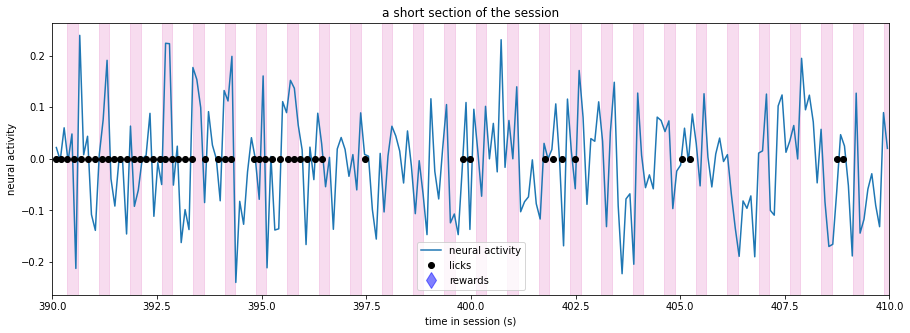

In [27]:
cell_specimen_ids = this_experiment_neural_data['cell_specimen_id'].unique()
cell_specimen_id = cell_specimen_ids[4]
initial_time = 390 # initial time for plot, in seconds
final_time = 410 # final time for plot, in seconds
fig, ax = plt.subplots(figsize = (15,5))
plot_neural_activity(ax, initial_time, final_time, this_experiment_neural_data, cell_specimen_id)
plot_licks(ax, initial_time, final_time)
plot_rewards(ax, initial_time, final_time)
plot_stimuli(ax, initial_time, final_time)

ax.legend(['neural activity', 'licks', 'rewards'])

ax.set_ylabel('neural activity')
ax.set_xlabel('time in session (s)')
ax.set_xlim(initial_time, final_time)
ax.set_title('a short section of the session');

In [28]:
this_experiment_neural_data.columns
cre_line_ids = this_experiment_neural_data['cre_line'].unique()
print(cre_line_ids)

['Sst-IRES-Cre']


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


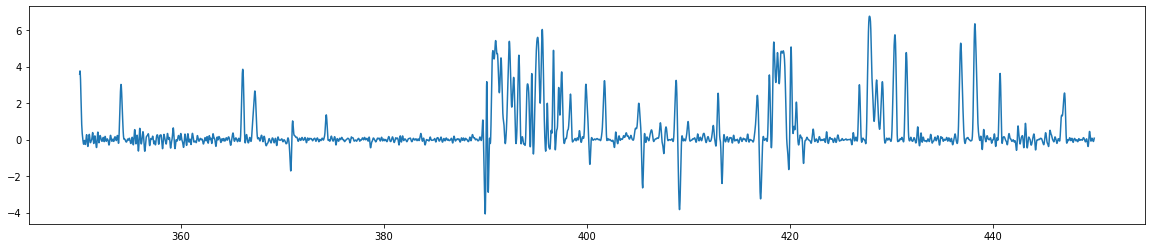

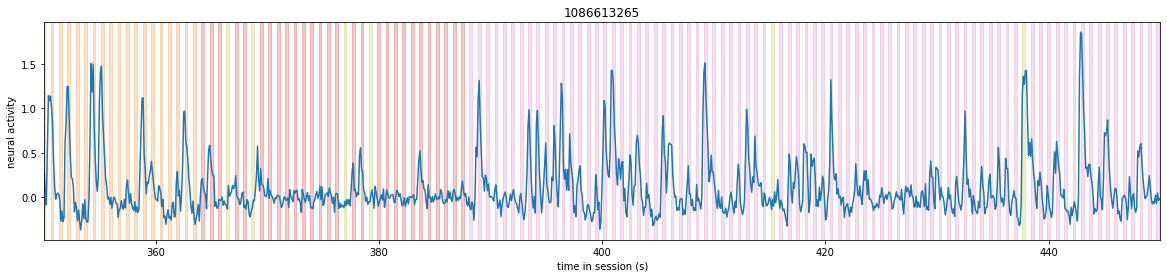

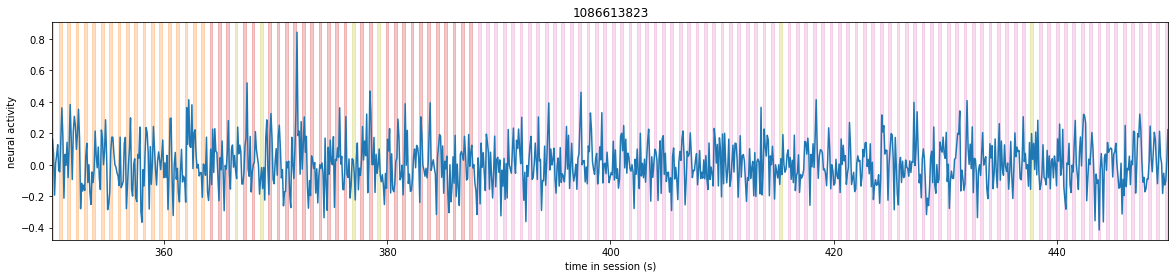

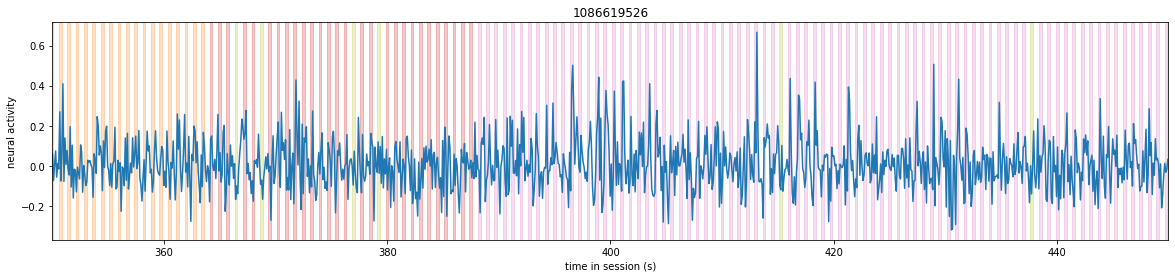

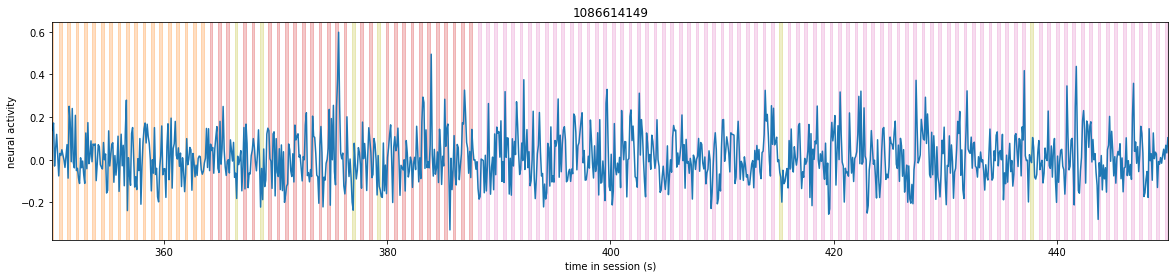

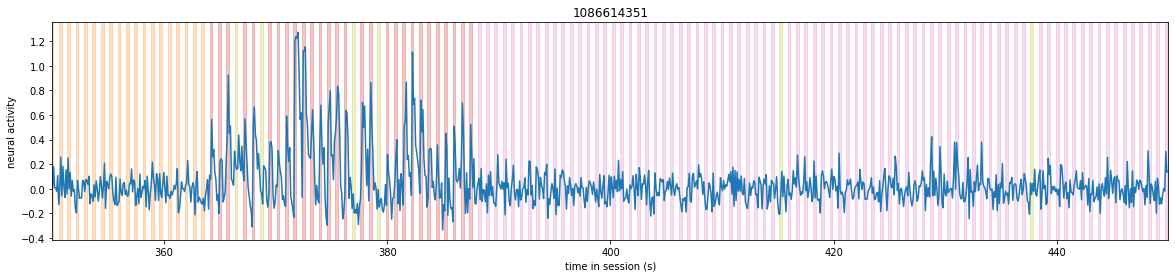

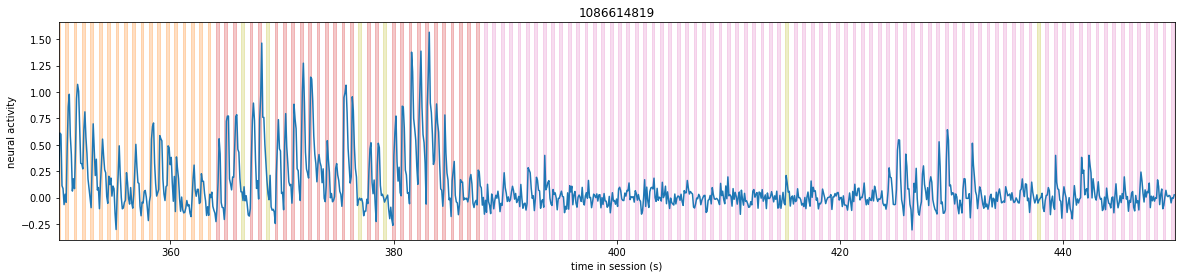

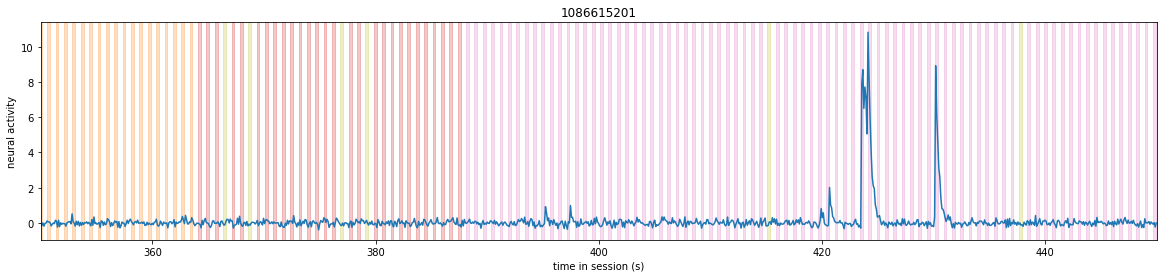

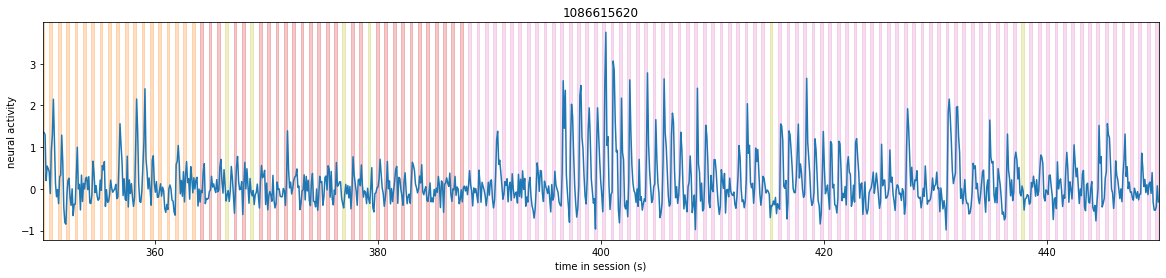

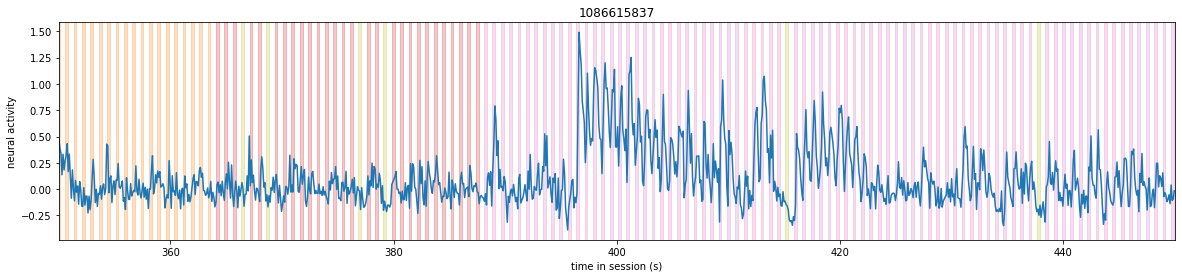

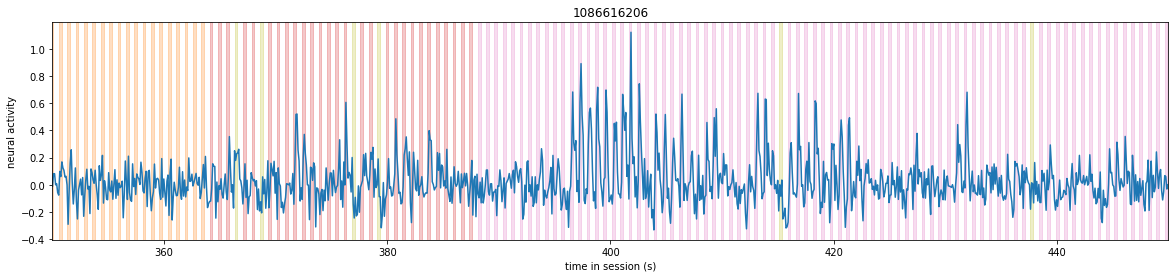

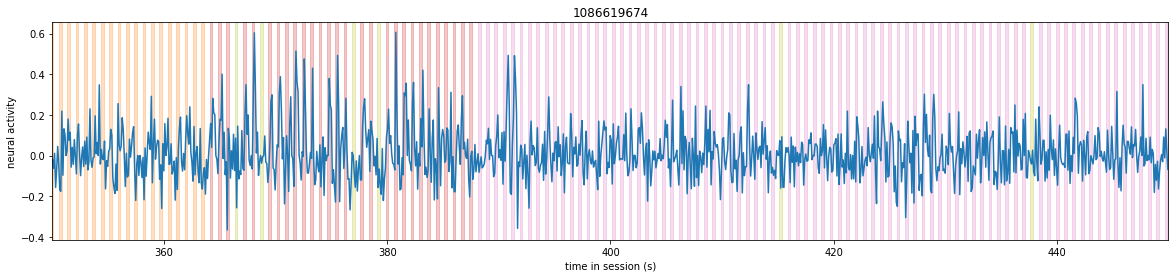

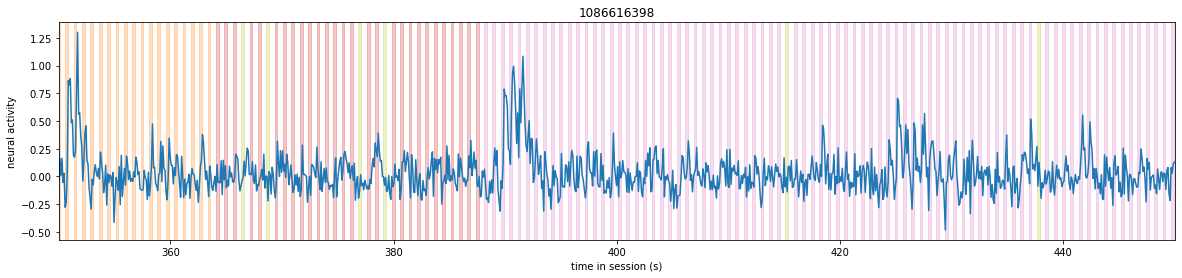

In [29]:
cell_specimen_ids = this_experiment_neural_data['cell_specimen_id'].unique()

initial_time = 350 # initial time for plot, in seconds
final_time = 450 # final time for plot, in seconds

fig, ax = plt.subplots(figsize = (20,4))
plot_running(ax, initial_time, final_time)

for id in cell_specimen_ids:
  fig, ax = plt.subplots(figsize = (20,4))
  plot_neural_activity(ax, initial_time, final_time, this_experiment_neural_data, id)
  plot_stimuli(ax, initial_time, final_time)
  ax.set_ylabel('neural activity')
  ax.set_xlabel('time in session (s)')
  ax.set_xlim(initial_time, final_time)
  ax.set_title(id);

# EXTRACT AND AVERAGE ACTIVITY OF ALL THE CELLS IN THE SESSION


### Make a dictionary of experiments in one session

In [30]:
def session_experiments(ophys_session_id):
  experiments = {}
  ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
  for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
  return experiments

### Make a neural data dataset for one session

In [31]:
def session_neural_data(this_session_experiments):
  neural_data = []
  for ophys_experiment_id in tqdm(this_session_experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = this_session_experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
  # concatate the list of dataframes into a single dataframe
  neural_data = pd.concat(neural_data)
  
  return neural_data

### Make a session dictionary including a list of experiments and a dataframe with neural data

In [32]:
def make_session_dictionary_entry(ophys_session_id):
  this_session_experiments = session_experiments(ophys_session_id) #creates a dictionary of experiments in the session (experiment_id as a key)
  this_session_neural_data = session_neural_data(this_session_experiments)
  return [this_session_experiments, this_session_neural_data]

In [33]:
session_dictionary = {}

### Extract data for one cell and align it with event times

In [34]:
def align_cell_with_event(ophys_session_id, ophys_experiment_id, cell_specimen_id, window_width = 0.5, session_dictionary = session_dictionary):
  #the function requires neural data for all the experiments in the session and a dictionary with experiments ids

  #identify experiment & corresponding neural data
  this_experiment = session_dictionary[ophys_session_id][0][ophys_experiment_id]
  neural_data = session_dictionary[ophys_session_id][1]

  # extract hits
  etr_hit = mindscope_utilities.event_triggered_response(
    data = neural_data.query('ophys_experiment_id == @ophys_experiment_id and cell_specimen_id == @cell_specimen_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = this_experiment.trials.query('hit')['change_time'],
    t_before=window_width,
    t_after=window_width,
    output_sampling_rate = 50,
  )

  # add hit indicator
  etr_hit['hit_miss'] = 'hit'

  # extract misses
  etr_miss = mindscope_utilities.event_triggered_response(
    data = neural_data.query('ophys_experiment_id == @ophys_experiment_id and cell_specimen_id == @cell_specimen_id'),
    t = 'timestamps',
    y = 'dff',
    event_times = this_experiment.trials.query('miss')['change_time'],
    t_before=window_width,
    t_after=window_width,
    output_sampling_rate = 50,
  )

  # add miss indicator
  etr_miss['hit_miss'] = 'miss'

  #concatenate
  etr = pd.concat([etr_hit, etr_miss])
  print(len(etr))

  #add session and cell specimen id, metadata
  etr['ophys_session_id'] = ophys_session_id
  etr['ophys_experiment_id'] = ophys_experiment_id  
  etr['cell_specimen_id'] = cell_specimen_id
  etr['cell_roi_id'] = this_experiment.dff_traces.loc[cell_specimen_id]['cell_roi_id']
  etr['cre_line'] = this_experiment.metadata['cre_line']
  etr['imaging_depth'] = this_experiment.metadata['imaging_depth']
  etr['mouse_id'] = this_experiment.metadata['mouse_id']
  etr['sex'] = this_experiment.metadata['sex']

  return etr

### Get cells from one session

In [35]:
def get_cells_from_session(ophys_session_id, session_dictionary = session_dictionary):
  ophys_experiment_ids = list(session_dictionary[ophys_session_id][0].keys())

  aligned_cells = []
  for ophys_experiment_id in ophys_experiment_ids:
    cells_specimen_ids = session_dictionary[ophys_session_id][0][ophys_experiment_id].dff_traces.index
    for cell_specimen_id in cells_specimen_ids:
      print('Session:', ophys_session_id, 'Experiment:', ophys_experiment_id, 'Cell:', cell_specimen_id)
      this_cell = align_cell_with_event(ophys_session_id, ophys_experiment_id, cell_specimen_id)
      #print(this_cells.keys())
      print('N_events in this session & cell: ', len(this_cell['event_time'].unique()))
      print('Length of cell signal:', len(this_cell))
      aligned_cells.append(this_cell)
  
  aligned_cells = pd.concat(aligned_cells)

  return aligned_cells

In [36]:
ophys_session_ids = [951410079] #[993727065, 954981981]#, 992232718, 977726123, 1010159622, 1000580083, 982431228]
for ophys_session_id in ophys_session_ids:
  session_dictionary[ophys_session_id] = make_session_dictionary_entry(ophys_session_id)

100%|██████████| 7/7 [00:41<00:00,  5.96s/it]


In [37]:
session_dictionary.keys()

dict_keys([951410079])

In [38]:
ophys_session_id = 951410079#ophys_session_ids[1]
my_cells = get_cells_from_session(ophys_session_id)

Session: 951410079 Experiment: 951980471 Cell: 1086613265
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086613823
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086619526
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086614149
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086614351
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086614819
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086615201
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086615620
9231
N_events in this session & cell:  

In [39]:
my_cells = []
for ophys_session_id in ophys_session_ids:
  this_cells = get_cells_from_session(ophys_session_id)
  #print('N_events in this session: ', len(this_cells['event_number'].unique()))
  my_cells.append(this_cells)
  print(type(my_cells))
  #print(len(this_cells))
  print(this_cells.keys())

my_cells = pd.concat(my_cells)

Session: 951410079 Experiment: 951980471 Cell: 1086613265
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086613823
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086619526
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086614149
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086614351
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086614819
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086615201
9231
N_events in this session & cell:  181
Length of cell signal: 9231
Session: 951410079 Experiment: 951980471 Cell: 1086615620
9231
N_events in this session & cell:  

In [40]:
#len(my_cells)
5420107/601

9018.480865224625

In [41]:
my_cells.head()

,time,dff,event_number,event_time,hit_miss,ophys_session_id,ophys_experiment_id,cell_specimen_id,cell_roi_id,cre_line,imaging_depth,mouse_id,sex
0,-0.50,-0.018922,0,526.255845,hit,951410079,951980471,1086613265,1080743723,Sst-IRES-Cre,150,457841,F
1,-0.48,-0.018922,0,526.255845,hit,951410079,951980471,1086613265,1080743723,Sst-IRES-Cre,150,457841,F
2,-0.46,-0.018922,0,526.255845,hit,951410079,951980471,1086613265,1080743723,Sst-IRES-Cre,150,457841,F
3,-0.44,-0.018922,0,526.255845,hit,951410079,951980471,1086613265,1080743723,Sst-IRES-Cre,150,457841,F
4,-0.42,-0.018922,0,526.255845,hit,951410079,951980471,1086613265,1080743723,Sst-IRES-Cre,150,457841,F


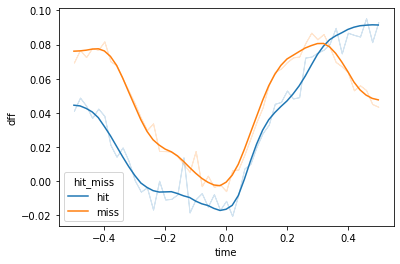

In [42]:
sns.lineplot(
    data=my_cells,
    x='time',
    y='dff',
    hue='hit_miss',
    n_boot=1
)

# Principal component analysis for dimensionality reduction

In [43]:
# Prepare matrix
size0 = int(len(my_cells)/301)
PCA_matrix = np.zeros((size0, 300)) #np.zeros( int(len(my_cells)/301), 300)  #len(my_cells['cell_specimen_id'].unique()), 600) #[len(my_cells)/601,600])
#for index, row in my_cells.iterrows():
#  row['time']
#  dt = 0.02
#  xindexnew = int((row['time'] + 3)/dt)
#  yindexnew = index//301
#  PCA_matrix[xindexnew,yindexnew] = row['dff'] 

#validate that all cells are being collected
# nan lines and columns?

#my_cells_av = my_cells[['ophys_experiment_id', 'cell_specimen_id', 'hit_miss', 'time','dff']].groupby(['ophys_experiment_id', 'cell_specimen_id', 'hit_miss', 'time'], as_index=False).mean()

#my_cells['cell_specimen_id*eventnumber'] = my_cells['cell_specimen_id']*'['eventnumber']
#my_cells['cell_specimen_id'].unique()
#my_cells.pivot_table(my_cells, index = 'cell_roi_id', columns='time', values='dff').head() 



dff_by_cell_over_time_hit  = my_cells.loc[my_cells['hit_miss'] == 'hit' ].groupby(['cell_specimen_id', 'time'], as_index=False).mean().pivot(index='cell_specimen_id', columns='time', values='dff')
dff_by_cell_over_time_hit.head()

dff_by_cell_over_time_miss = my_cells.loc[my_cells['hit_miss'] == 'miss'].groupby(['cell_specimen_id', 'time'], as_index=False).mean().pivot(index='cell_specimen_id', columns='time', values='dff')
dff_by_cell_over_time_miss.head()

dff_by_cell_over_time_always = my_cells.groupby(['cell_specimen_id', 'time'], as_index=False).mean().pivot(index='cell_specimen_id', columns='time', values='dff')
dff_by_cell_over_time_always.head()

dff_by_cell_over_time_hitminusalways = dff_by_cell_over_time_hit - dff_by_cell_over_time_always

dff_by_cell_over_time_hitminusmiss = dff_by_cell_over_time_hit - dff_by_cell_over_time_miss




# Cross-correlation between neuronal signals




In [44]:

Ncells = len(dff_by_cell_over_time_hitminusmiss)
tslength = dff_by_cell_over_time_hitminusmiss.shape[1]
print(Ncells, tslength)
#ts1 = dff_by_cell_over_time_hit.iloc[2,:]
#print(ts1)

#dff_by_cell_over_time_miss.loc[dff_by_cell_over_time_miss['cell_specimen_id']==['1086490519']]

#print(dff_by_cell_over_time_hit)
#dff_by_cell_over_time_hit_lag1 = dff_by_cell_over_time_hit.slice_shift(3,1)
#print(dff_by_cell_over_time_hit_lag1)
#print(dff_by_cell_over_time_hit_lag1.shape)

#ts2 = dff_by_cell_over_time_hit.iloc[:,3:]
#print(ts2)

#print(ts2.shape)

#timelag = -3
#ts1= dff_by_cell_over_time_hitminusmiss.slice_shift(timelag,1) #dff_by_cell_over_time_hit.iloc[n1,-timelag:] (-3 = -50:44)
#print(ts1)       
#ts2 = dff_by_cell_over_time_hitminusmiss.iloc[:,-timelag:(tslength)] #dff_by_cell_over_time_hit.iloc[n2,0:tslength-timelag] (-3: -44:50)
#print(ts2)

timelag = 3
#ts1 = dff_by_cell_over_time_hitminusmiss.slice_shift(timelag,1) #length = length-timelag (0 = -50:50) (3 = -44:50)
#print(ts1)     
ts2 = dff_by_cell_over_time_hitminusmiss.iloc[:,0:(tslength-timelag)] #(0 = -50:50) (3 = -50:44)
print(ts2)     

88 51
time                 -0.50     -0.48     -0.46     -0.44     -0.42     -0.40  \
cell_specimen_id                                                               
1086606974        0.157486  0.157395  0.136457  0.094150  0.045644  0.001439   
1086607071        0.025058  0.025106  0.024036  0.018683  0.010090  0.000111   
1086607143        0.000322 -0.001169 -0.001619 -0.000038  0.000312 -0.000909   
1086607195       -0.003251 -0.003206 -0.003463 -0.005827 -0.014717 -0.026549   
1086607520       -0.057184 -0.057481 -0.051237 -0.041733 -0.031875 -0.017300   
...                    ...       ...       ...       ...       ...       ...   
1086622595        0.004739  0.004036  0.003124  0.002632  0.000539 -0.002778   
1086622778       -0.077889 -0.077116 -0.072936 -0.065540 -0.055112 -0.040092   
1086623189        0.050356  0.055700  0.038960  0.007300 -0.044595 -0.116714   
1086623621       -0.000843 -0.000711 -0.001855 -0.003358 -0.005612 -0.006837   
1086623929       -0.014482 -0.0146

<Figure size 1080x216 with 0 Axes>

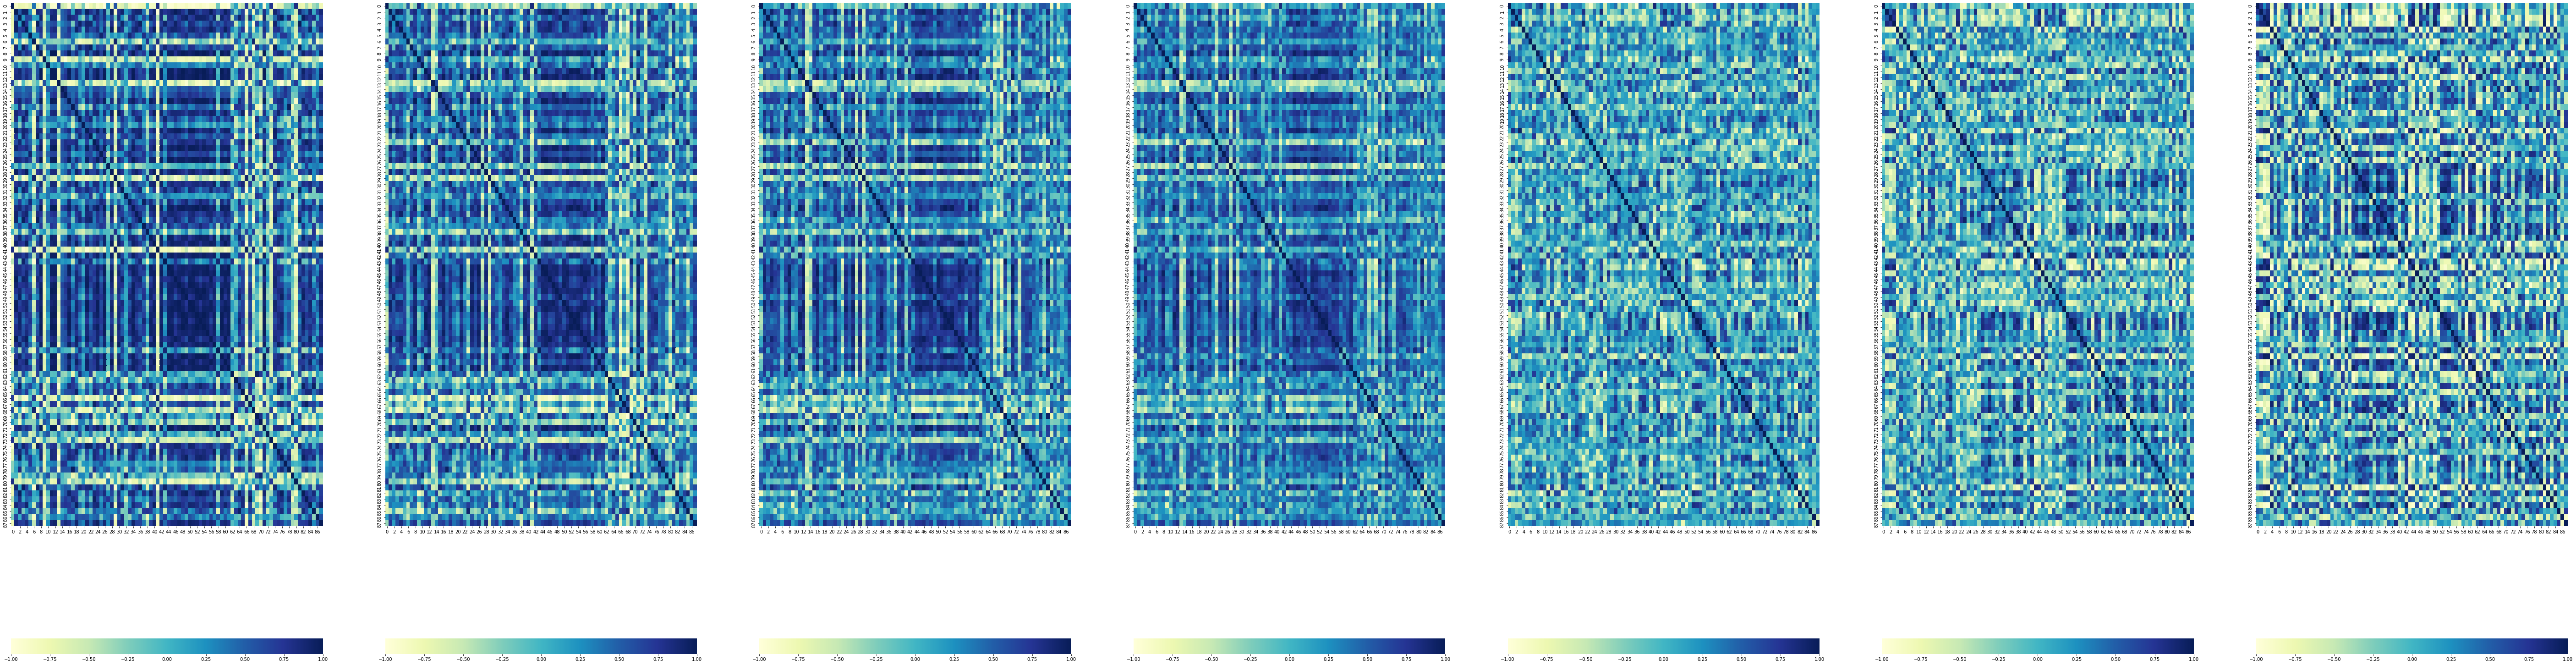

<Figure size 1080x216 with 0 Axes>

In [45]:
Ncells = len(dff_by_cell_over_time_hitminusmiss)
tslength = dff_by_cell_over_time_hitminusmiss.shape[1]

fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(100)

for timelag in range(-3*10, 4*10, 1*10):
  if timelag < 0:
    ts1= dff_by_cell_over_time_hitminusmiss.slice_shift(timelag,1) #dff_by_cell_over_time_hit.iloc[n1,-timelag:]
    ts2 = dff_by_cell_over_time_hitminusmiss.iloc[:,-timelag:(tslength)] #dff_by_cell_over_time_hit.iloc[n2,0:tslength-timelag]
  else:
    ts1 = dff_by_cell_over_time_hitminusmiss.slice_shift(timelag,1) #length = length-timelag
    ts2 = dff_by_cell_over_time_hitminusmiss.iloc[:,0:(tslength-timelag)]
  testje = np.corrcoef(ts1, ts2) #yields a matrix of 2*Nneurons x 2*Nneurons
  testje = testje[0:Ncells, Ncells:2*Ncells] #so select part that is informative
  sppos = timelag/10+4
  ax = fig.add_subplot(1, 7, sppos)
  sns.heatmap(testje, ax = ax, cmap ="YlGnBu", vmin=-1, vmax=1, cbar_kws={"orientation": "horizontal"})
  
  del testje

plt.figure(figsize=(15,3))

<Figure size 1080x216 with 0 Axes>

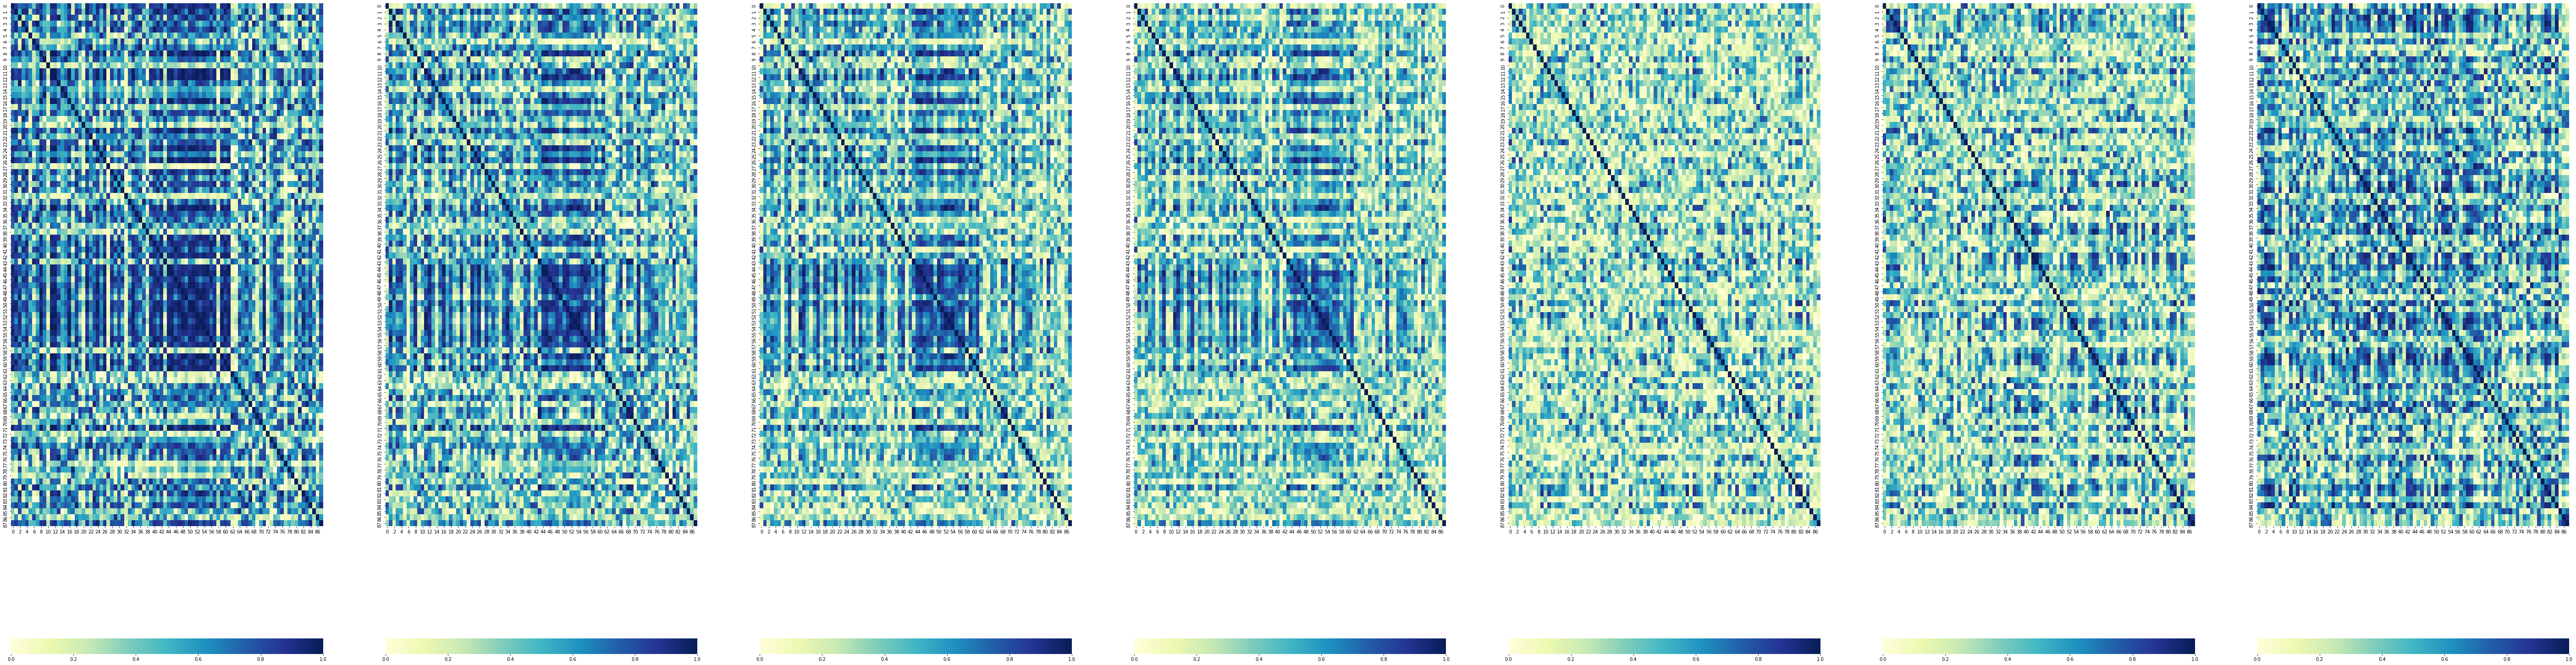

<Figure size 1080x216 with 0 Axes>

In [46]:
Ncells = len(dff_by_cell_over_time_hitminusmiss)
tslength = dff_by_cell_over_time_hitminusmiss.shape[1]

fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(100)

for timelag in range(-3*10, 4*10, 1*10): 
  if timelag < 0:
    ts1= dff_by_cell_over_time_hitminusmiss.slice_shift(timelag,1) #dff_by_cell_over_time_hit.iloc[n1,-timelag:]
    ts2 = dff_by_cell_over_time_hitminusmiss.iloc[:,-timelag:(tslength)] #dff_by_cell_over_time_hit.iloc[n2,0:tslength-timelag]
  else:
    ts1 = dff_by_cell_over_time_hitminusmiss.slice_shift(timelag,1) #length = length-timelag
    ts2 = dff_by_cell_over_time_hitminusmiss.iloc[:,0:(tslength-timelag)]
  testje = np.corrcoef(ts1, ts2) #yields a matrix of 2*Nneurons x 2*Nneurons
  testje = testje[0:Ncells, Ncells:2*Ncells] #so select part that is informative
  testje_abs = abs(testje)
  sppos = timelag/10+4
  ax = fig.add_subplot(1, 7, sppos)
  sns.heatmap(testje_abs, ax = ax, cmap ="YlGnBu", vmin=0, vmax=1, cbar_kws={"orientation": "horizontal"})
  
  del testje

plt.figure(figsize=(15,3))

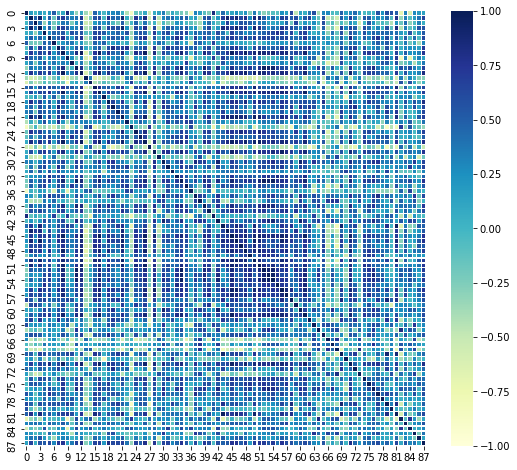

In [47]:
cc_hitminusmiss = np.corrcoef(dff_by_cell_over_time_hitminusmiss)
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(cc_hitminusmiss, ax = ax, cmap ="YlGnBu", linewidths = 0.1, vmin=-1, vmax=1)

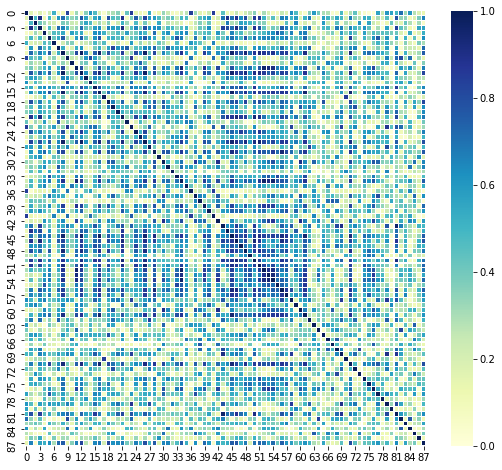

In [48]:
cc_hitminusmiss_abs = abs(cc_hitminusmiss)
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(cc_hitminusmiss_abs, ax = ax, cmap ="YlGnBu", linewidths = 0.1, vmin=0, vmax=1)

In [52]:
#cell_specimen_id # use this as an identifier to select the responsive & non-responsive neurons
# Make extra column in dff_by_cell_over_time_hitminusmiss that classifies neurons as responsive(1) or non-responsive(0)
dff_by_cell_over_time_hitminusmiss.insert(0,"responsiveness", np.zeros([Ncells,]), True)
dff_by_cell_over_time_hitminusmiss["cell_specimen_id" == "1080738985"] = 1;
dff_by_cell_over_time_hitminusmiss["cell_specimen_id" == "1080738999"] = 1;
#print(dff_by_cell_over_time_hitminusmiss)
#print(dff_by_cell_over_time_hitminusmiss.shape)

selection = dff_by_cell_over_time_hitminusmiss.groupby(['responsiveness' == 1])
print(selection)